<a href="https://colab.research.google.com/github/mindymj777/Recommdation-/blob/main/Recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 模組載入

In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats 
from sklearn.metrics.pairwise import cosine_similarity
from operator import itemgetter
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

#### 資料集載入

In [ ]:
from urllib.request import urlretrieve
import zipfile

urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()

#### 資料集資訊

由943位使用者為1682部電影進行觀影評分, 共100000份

In [ ]:
#資料集介紹
dataset_info = pd.read_csv("ml-100k/u.info")
dataset_info

,943 users
0,1682 items
1,100000 ratings


user的職業共21種、電影共有19類型分類

In [ ]:
occupation=pd.read_csv("ml-100k/u.occupation",header=None, names=["occupation"])
genre = pd.read_csv("ml-100k/u.genre", sep="|", header=None)
occupation.info()
genre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   occupation  21 non-null     object
dtypes: object(1)
memory usage: 296.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       19 non-null     object
 1   1       19 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 432.0+ bytes


共943位使用者，每一位user共有5個屬性

In [ ]:
#指投影片的User Data
users = pd.read_csv("ml-100k/u.user", sep="|", header=None, names=["user_id", "age", "gender", "occupation", "zip_code"])
users

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


共100000份評分，且每個評分有user_id,item_id,rating

In [ ]:
#投影片的Rating Data
ratings = pd.read_csv("ml-100k/u.data", sep='\t', header=None, names=["user_id", "item_id", "rating", "timestamp"])
ratings=ratings.drop(["timestamp"], axis=1)
ratings

,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
...,...,...,...
99995,880,476,3
99996,716,204,5
99997,276,1090,1
99998,13,225,2


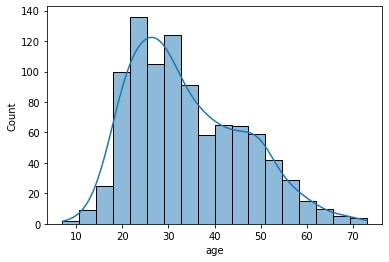

In [ ]:
sns.histplot(data=users[['age']], x='age', kde=True)

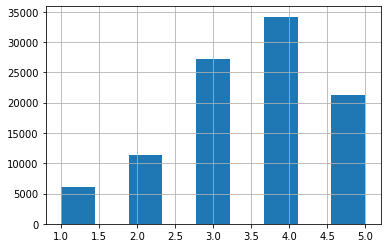

In [ ]:
ratings['rating'].hist(bins=9)

In [ ]:
#投影片的Movie Items
movies = pd.read_csv("ml-100k/u.item", encoding="ISO-8859-1",sep="|", header=None, names=["item_id", "title", "release_date", "video_release_date", "IMDb_URL",
         "unknown", "Action", "Adventure", "Animation","Children's", "Comedy", "Crime",
         "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", 
         "Romance", "Sci-Fi", "Thriller", "War", "Western"])
movies = movies.drop(columns=["video_release_date", "IMDb_URL"])
movies

,item_id,title,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
print(ratings['user_id'].nunique(),'unique users')
print(ratings['item_id'].nunique(),'unique movies')
print(ratings['rating'].nunique(),'unique rating')
print('The unique ratings are',sorted(ratings['rating'].unique()))


943 unique users
1682 unique movies
5 unique rating
The unique ratings are [1, 2, 3, 4, 5]


In [ ]:
rating_item=pd.DataFrame(pd.merge(movies,ratings).groupby(['item_id'])['rating'].agg(['count', 'mean', 'std']))
rating_item

,count,mean,std
item_id,,,
1,452,3.878319,0.927897
2,131,3.206107,0.966497
3,90,3.033333,1.212760
4,209,3.550239,0.965069
5,86,3.302326,0.946446
...,...,...,...
1678,1,1.000000,NaN
1679,1,3.000000,NaN
1680,1,2.000000,NaN


In [ ]:
rating_user = pd.DataFrame(pd.merge(movies,ratings).groupby(['user_id'])['rating'].agg(['count', 'mean', 'std']))
rating_user

,count,mean,std
user_id,,,
1,272,3.610294,1.263585
2,62,3.709677,1.030472
3,54,2.796296,1.219026
4,24,4.333333,0.916831
5,175,2.874286,1.362963
...,...,...,...
939,49,4.265306,0.974156
940,107,3.457944,1.012007
941,22,4.045455,0.898532


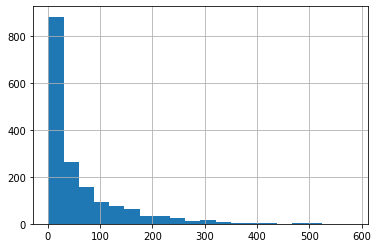

In [ ]:
rating_item.sort_values(by='count')['count'].hist(bins=20)

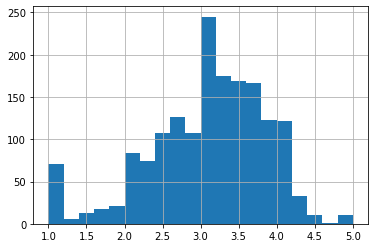

In [ ]:
rating_item.sort_values(by='mean')['mean'].hist(bins=20)

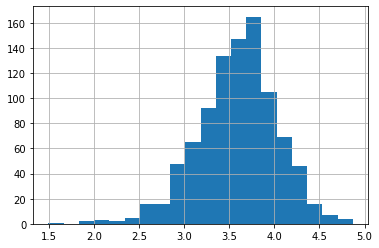

In [ ]:
rating_user.sort_values(by='mean')['mean'].hist(bins=20)

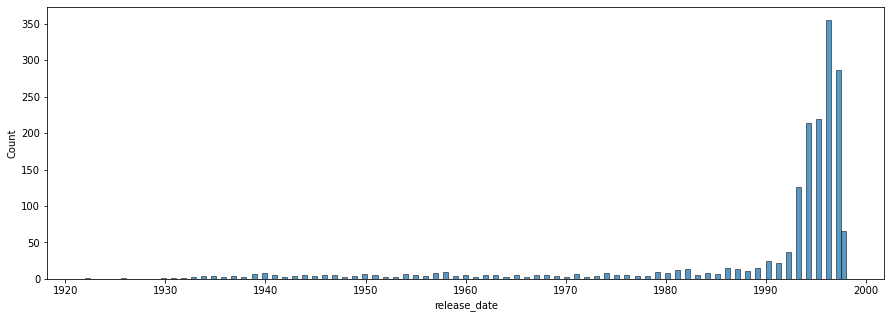

In [ ]:
year = pd.DatetimeIndex(movies['release_date']).year
plt.figure(figsize=(15,5))
sns.histplot(year)

Text(0.5, 1.0, 'Pie chart of occupation')

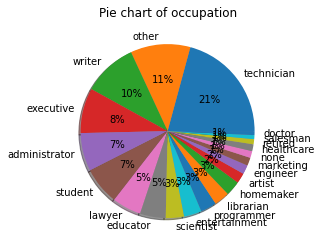

In [ ]:
plt.pie(users['occupation'].value_counts(),                  
    labels=users['occupation'].unique(), 
    autopct='%1.0f%%',
    pctdistance = 0.6,              #數字距圓心的距離
    textprops = {"fontsize" : 10},         #文字大小
    shadow=True)                    #設定陰影
plt.title("Pie chart of occupation", {"fontsize" : 12})  #設定標題及其文字大小 

#### Data preprocessing

In [ ]:
users_numeric = pd.get_dummies(users, columns=["gender"],drop_first=True).rename(columns={'gender_M':'gender'})
users_numeric

,user_id,age,occupation,zip_code,gender
0,1,24,technician,85711,1
1,2,53,other,94043,0
2,3,23,writer,32067,1
3,4,24,technician,43537,1
4,5,33,other,15213,0
...,...,...,...,...,...
938,939,26,student,33319,0
939,940,32,administrator,02215,1
940,941,20,student,97229,1
941,942,48,librarian,78209,0


In [ ]:
occupation_list = occupation.values
pd.to_numeric(users_numeric["occupation"].replace(occupation_list,list(range(0, len(occupation_list))), inplace=True))
users_numeric

,user_id,age,occupation,zip_code,gender
0,1,24,19,85711,1
1,2,53,13,94043,0
2,3,23,20,32067,1
3,4,24,19,43537,1
4,5,33,13,15213,0
...,...,...,...,...,...
938,939,26,18,33319,0
939,940,32,0,02215,1
940,941,20,18,97229,1
941,942,48,10,78209,0


#### Linear Regression預測評分:使用u1資料

讀取u1-u5 的訓練及測試集

In [ ]:
# train_file = []

# for i in range(1,6):
#  train_file.append(files_dir + "u{}.base".format(i))



# for i in range(1,len(train_file)+1):
#   #動態產生變數並賦予其值為df
#   exec('u{}.base = pd.DataFrame()'.format(i))
  
trains = {
        "u1":"",
        "u2":"",
        "u3":"",
        "u4":"",
        "u5":"",
}
tests = {
        "u1":"",
        "u2":"",
        "u3":"",
        "u4":"",
        "u5":"",
}
for _ in range(1,6):
  trains[f"u{_}"] = pd.read_csv(f"ml-100k/u{_}.base",sep="\t",header=None, names=["user_id", "item_id", "rating", "timestamp"])
  trains[f"u{_}"]=trains[f"u{_}"].drop(columns={'timestamp'})
  tests[f"u{_}"] = pd.read_csv(f"ml-100k/u{_}.base",sep="\t",header=None, names=["user_id", "item_id", "rating", "timestamp"])
  tests[f"u{_}"]=tests[f"u{_}"].drop(columns={'timestamp'})
#print(trains["u1"])


In [ ]:
user_item = pd.merge(movies,ratings).pivot_table(index = ["user_id"],columns = ["title"],values = "rating")
user_item.columns

In [ ]:
user_item_norm=user_item.subtract(user_item.mean(axis=0),axis=1)
user_item_norm

In [ ]:
item_sim_p=user_item_norm.corr()
item_sim_p

In [ ]:
sim_cosine=cosine_similarity(user_item.fillna(0))
sim_cosine

In [ ]:
userid=1
movie='Liar Liar (1997)'

userid_watched=pd.DataFrame(user_item_norm.loc[userid].dropna(axis=0,how='all').sort_values(ascending=False)).reset_index().rename(columns={userid:'rating'})
userid_watched

In [ ]:
movie_similarity=item_sim_p[movie].reset_index().rename(columns={movie:'similarity'}).sort_values('similarity', ascending=False)
movie_similarity

In [ ]:
userid_watched_sim= pd.merge(userid_watched, movie_similarity, on='title', how='inner')\
                .sort_values('similarity', ascending=False)[:5]
userid_watched_sim

In [ ]:
predicted_rating = round(np.average(userid_watched_sim['rating'],weights=userid_watched_sim['similarity']), 6)

print(f'The predicted rating for {movie} by user {userid} is {predicted_rating}' )

In [ ]:
def item_based_recommend(userid,sim_item_num,rec_num):
  #選出還沒評分的
  userid_unwatched=pd.DataFrame(user_item_norm.loc[userid].isna()).reset_index()
  userid_unwatched=userid_unwatched[userid_unwatched[userid]==True]['title'].tolist()
  #選出已經評分的
  userid_watched=pd.DataFrame(user_item_norm.loc[userid].dropna(axis=0,how='all').sort_values(ascending=False)).reset_index().rename(columns={userid:'rating'})

  rating_pred={}
  
  for movie in userid_unwatched:
    movie_similarity=item_sim_p[movie].reset_index().rename(columns={movie:'similarity'})
    userid_watched_sim=pd.merge(userid_watched,movie_similarity,on='title',how='inner').sort_values('similarity', ascending=False).dropna(axis=0,how='any')[:sim_item_num] 

    if(sum(userid_watched_sim['similarity'])!=0):
      predicted=round(np.average(userid_watched_sim['rating'],weights=userid_watched_sim['similarity']), 6)
    else:
      predicted=0
    rating_pred[movie]=predicted
  
  return pd.DataFrame(sorted(rating_pred.items(),key=itemgetter(1),reverse=True)[:rec_num]).rename(columns={0: 'title', 1: 'rating'})

In [ ]:
recommend_movie=item_based_recommend(userid=1,sim_item_num=5,rec_num=3) #推薦用戶5，參考前3名相似的鄰居，推薦3個電影
recommend_movie

In [ ]:
userid=int(input('Enter the user_id='))
sim_item_num=int(input('Enter the number of neighbor='))
rec_num=int(input('Enter the number of recommender='))
recommend_movie=item_based_recommend(userid,sim_item_num,rec_num)
print(f'The top {rec_num} recommend movies :')
recommend_movie